In [1]:
import nibabel as nib
import hcp_utils as hcp
import numpy as np
# Specify the path to the NIfTI file
nifti_path = '/Users/adam/Downloads/sub-MDMA001_ses-00_task-emotion_acq-mb_dir-pe0_run-0_space-MNI152NLin6Asym_res-2_desc-denoised_bold.nii.gz'
# Load the NIfTI file
nifti_image = nib.load(nifti_path)
nifti_data=nifti_image.get_fdata()

# Get the header from the NIfTI image
nifti_header = nifti_image.header

# Retrieve the resolution
resolution = nifti_header.get_zooms()

# Print the resolution
print("Resolution:", resolution)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Resolution: (2.0, 2.0, 2.0, 1.0)


In [2]:
import matplotlib.pyplot as plt

Resolution: (2.0, 2.0, 2.0)


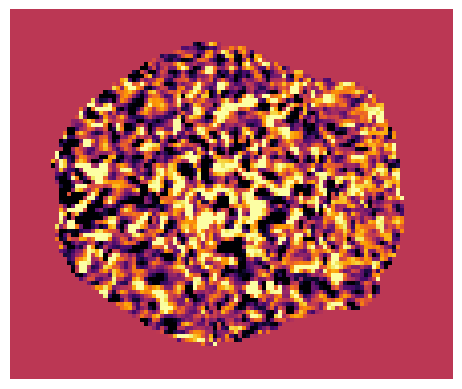

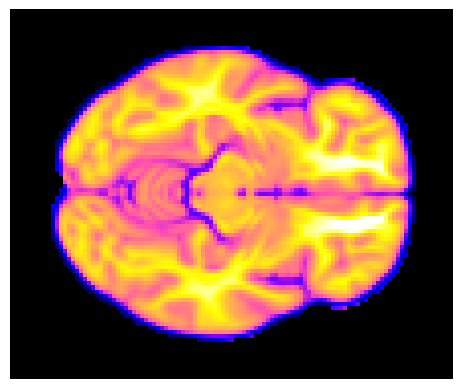

(22, 21, 13, 187)

In [3]:
# Define the bounding box coordinates
y_start, y_end = 45, 66
x_start, x_end = 33, 55
z_start, z_end = 33, 46

# Extract the spatial subset
subset = nifti_data[x_start:x_end, y_start:y_end, z_start:z_end,:]

# and plot slices on MNI to clarify exactly what space is being inquiried
mni_path = '/Users/adam/Downloads/MNI152_T1_2mm_Brain.nii.gz'
# Load the NIfTI file
mni_image = nib.load(mni_path)
mni_data=mni_image.get_fdata()

# Extract the spatial subset
mnisubset = mni_data[x_start:x_end, y_start:y_end, z_start:z_end]
# Get the header from the NIfTI image
nifti_header = mni_image.header

# Retrieve the resolution
resolution = nifti_header.get_zooms()

# Print the resolution
print("Resolution:", resolution)

# Plot the central slice along the z-axis (assuming it's the axial plane)
z_slice = 30
plt.imshow(nifti_data[:, :, z_slice,0], cmap='inferno',vmin=-10, vmax=10)
plt.axis('off')
plt.show()

plt.imshow(mni_data[:, :, z_slice], cmap='gnuplot2',vmin=0,vmax=8000)
plt.axis('off')
plt.show()

subset.shape

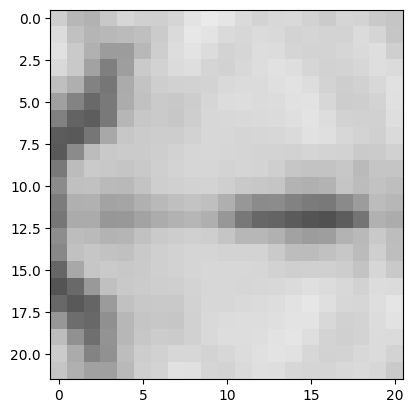

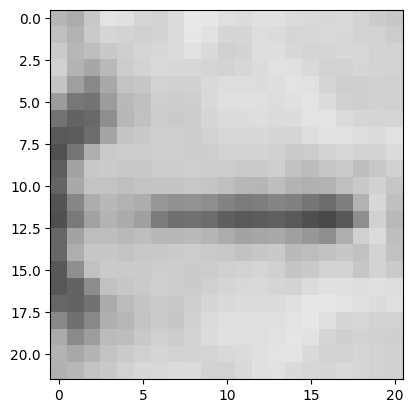

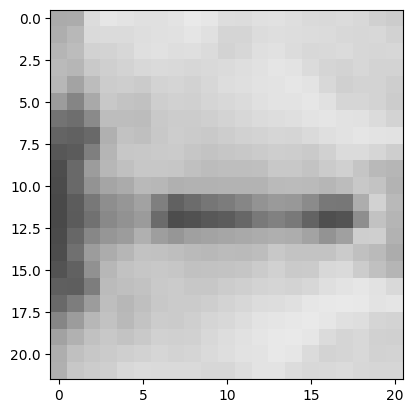

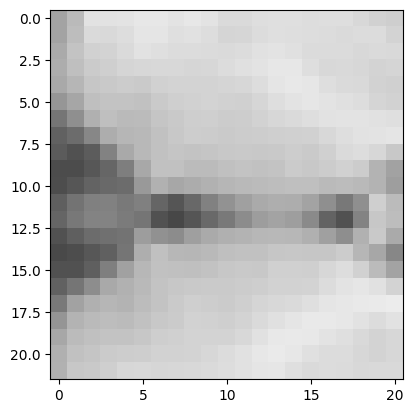

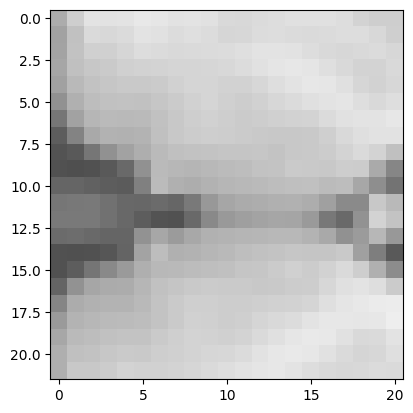

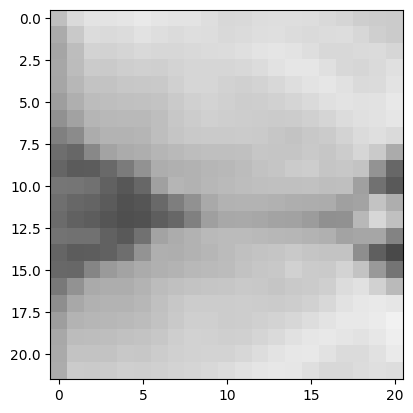

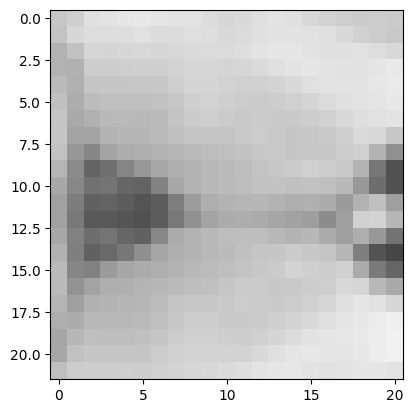

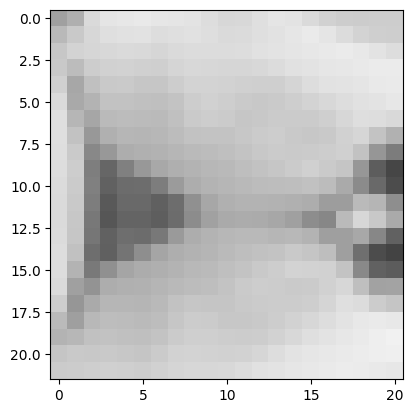

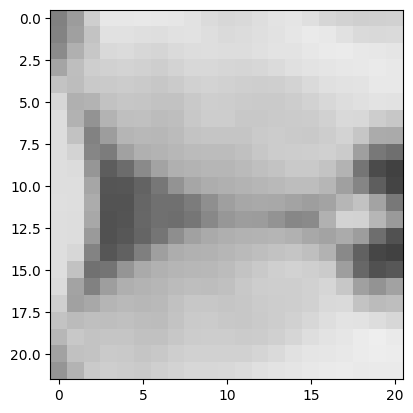

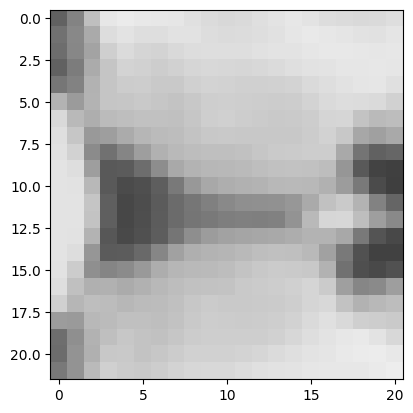

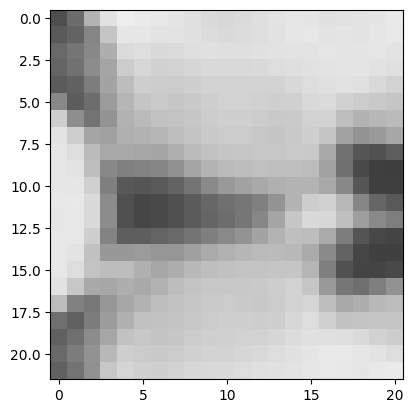

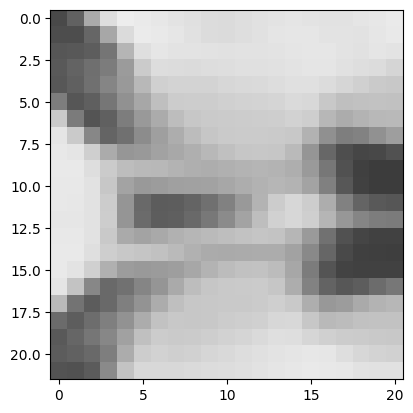

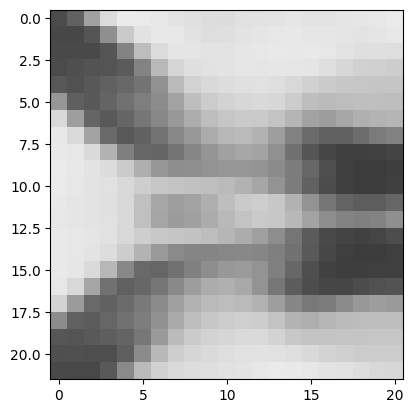

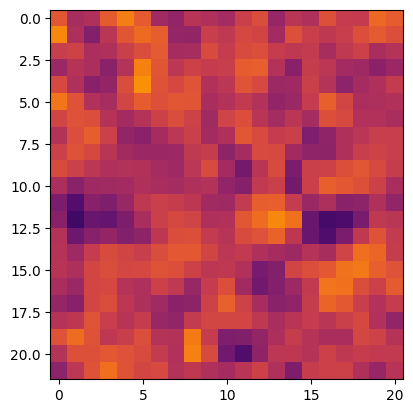

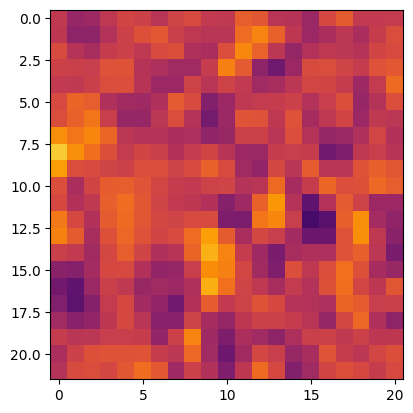

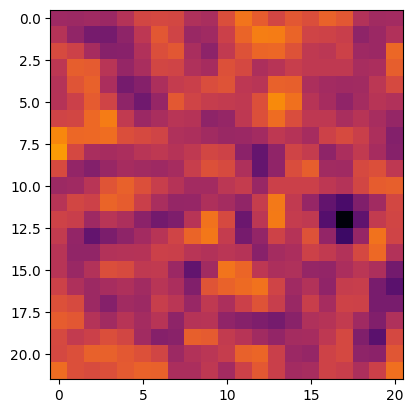

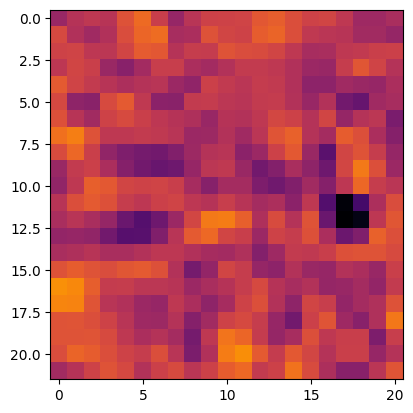

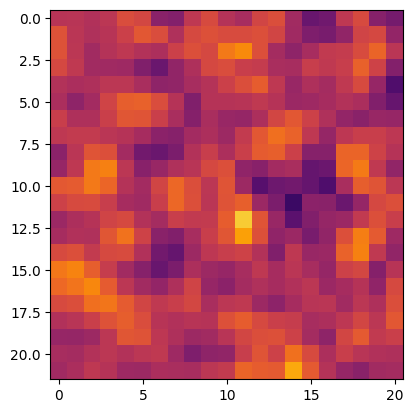

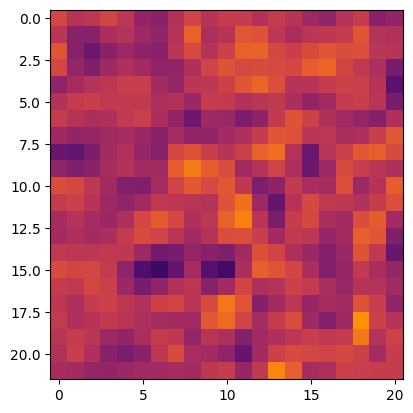

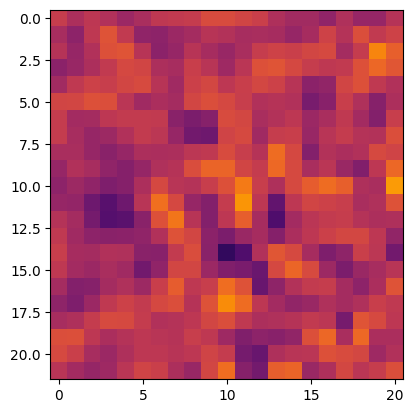

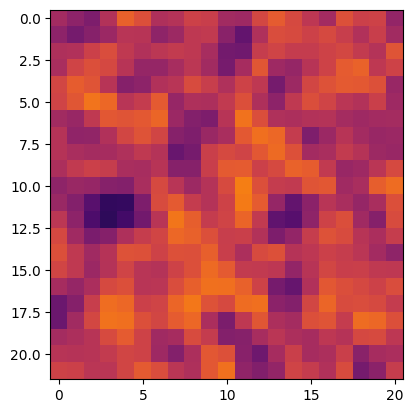

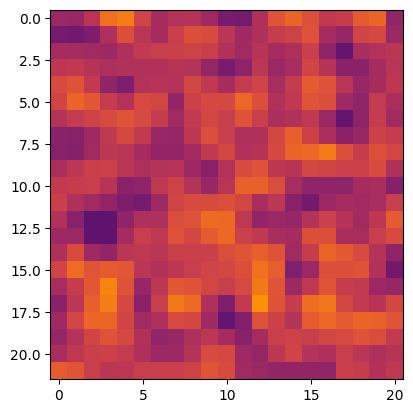

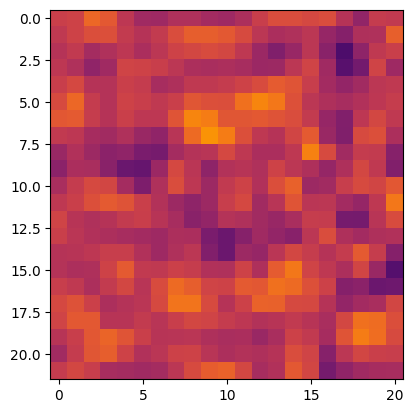

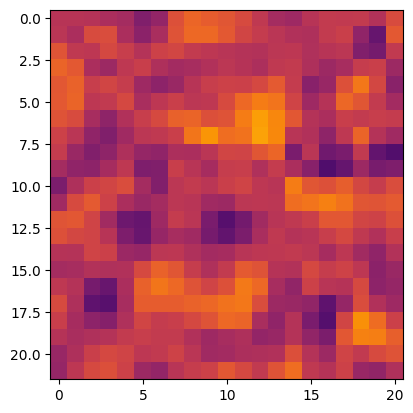

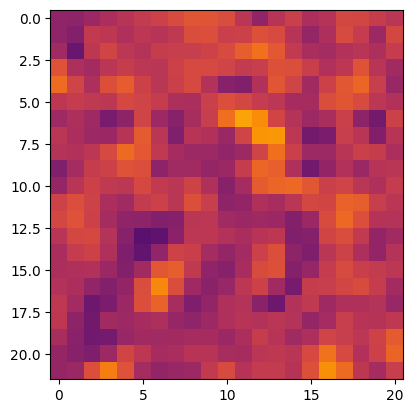

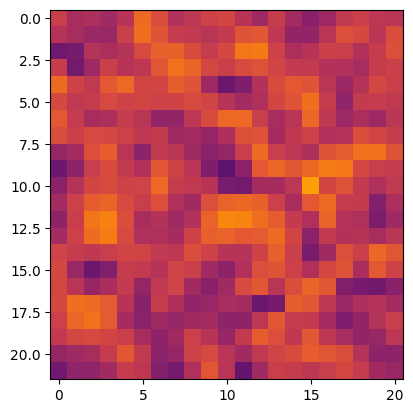

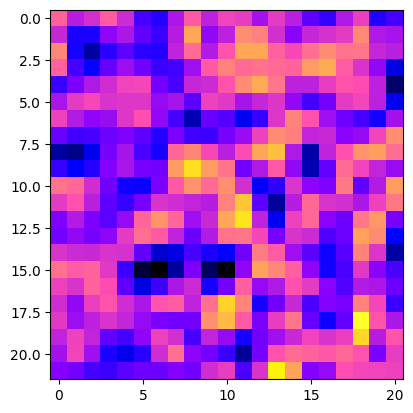

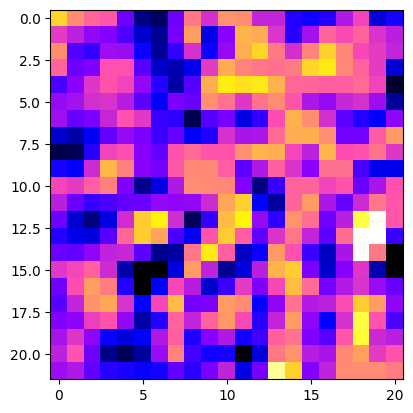

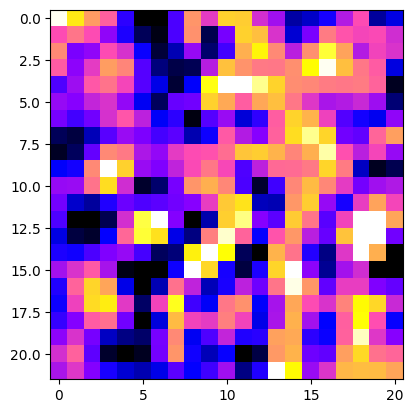

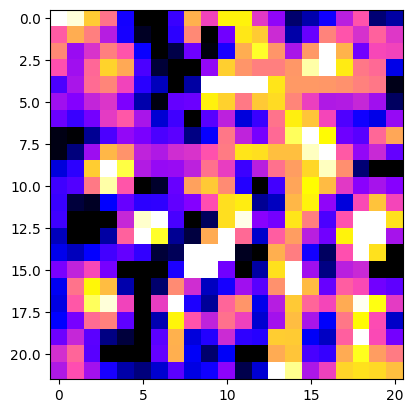

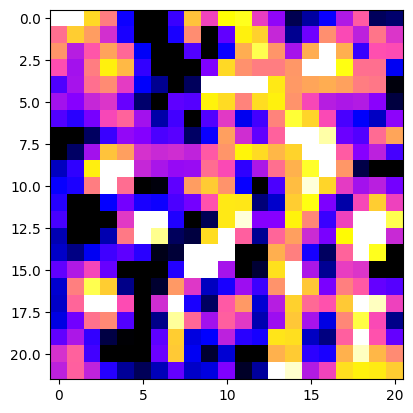

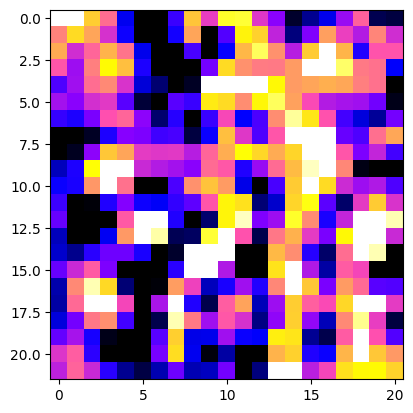

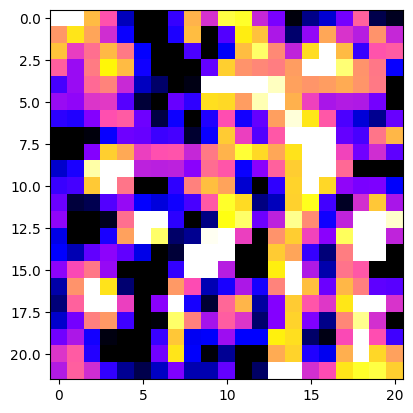

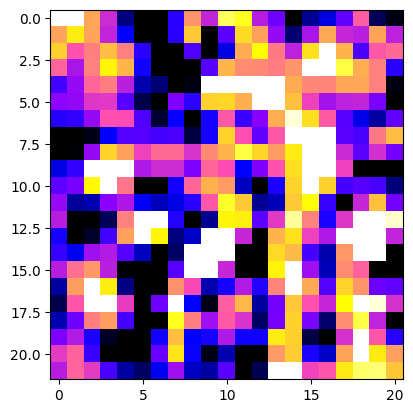

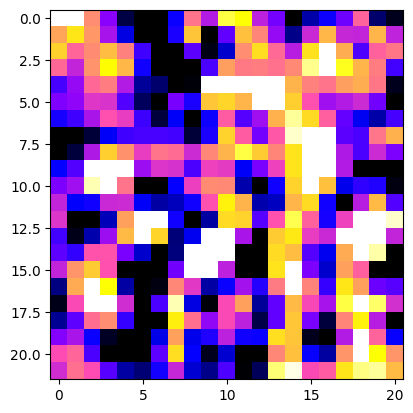

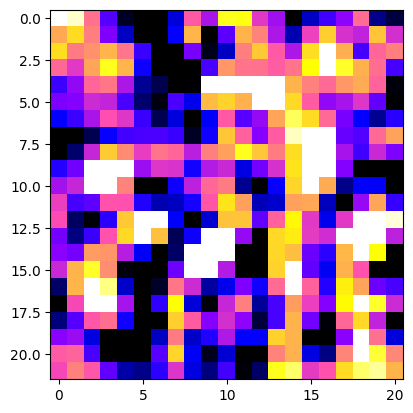

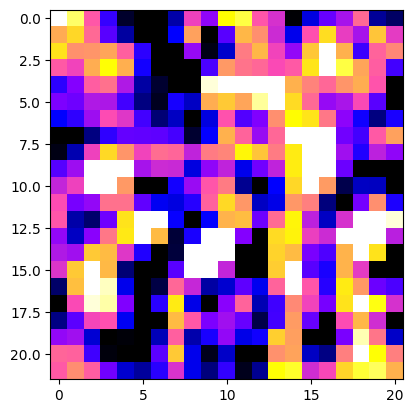

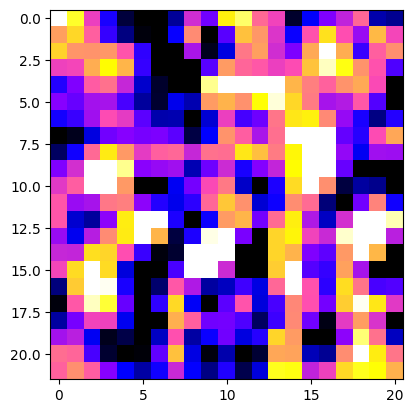

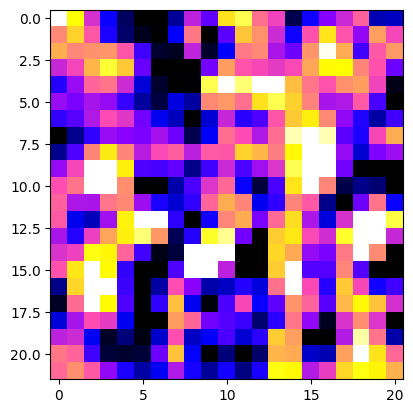

In [4]:
num_slices = z_end - z_start

for i, z_slice in enumerate(range(z_start, z_end)):
    plt.imshow(mnisubset[:, :, i], cmap='gray',vmin=0, vmax=8000)
    plt.show()
 
# same spatial dimensions for one functional image
for i, z_slice in enumerate(range(z_start, z_end)):
    plt.imshow(subset[:, :, i,0], cmap='inferno',vmin=-50, vmax=50)
    plt.show()
    
# one slice over time
for i, z_slice in enumerate(range(z_start, z_end)):
    plt.imshow(subset[:, :, 5,i], cmap='gnuplot2',vmin=-30, vmax=30)
    plt.show() 

In [ ]:
# now that the box is bounded, try fitting a few optical flow methods in first three frames

In [136]:
from imes4d.PyrLK3D import PyrLK3D
from imes4d.utils import Timer, ransac, blend_volumes, create_dummy_data
from mpl_toolkits.mplot3d import Axes3D
# create image 1 and 2 from bounded box of fmri series image 1 and 2
image1=subset[:,:,:,0].astype(np.float32)
image2=subset[:,:,:,1].astype(np.float32)
# previous points
#with Timer('harris'):
#    prev_pts = PyrLK3D.harris_corner_3d(image1,min_distance=3)
prev_pts=points[1:2000,:]

In [137]:
# create the optical flow object
lk = PyrLK3D(image1, image2, prev_pts, win_size=(4, 4, 4), levels=5, eps=1e-3, max_iterations=200)

In [138]:
# calculate optical flow, pyramidal lukas-kanade (https://github.com/mlaves/imes4d/blob/master/imes4d/PyrLK3D.py)
with Timer('pyr_lk'):
        flow, err, it = lk.calc_flow()

[pyr_lk]
Elapsed: 1094.3102793693542 s


In [139]:
# find best 25 % matches
mean_err = np.mean(np.sort(err)[:int(len(err) / 4)])
best_flow = np.array([i for i, e in zip(flow, err) if e < mean_err])
best_prev = np.array([i for i, e in zip(prev_pts, err) if e < mean_err])

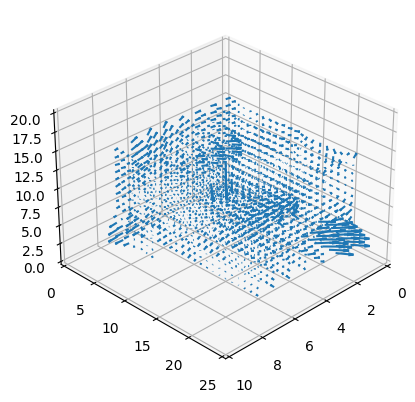

In [147]:
# Create a new figure and 3D axes
fig3d = plt.figure('p')
ax3 = fig3d.add_subplot(111, projection='3d')

# Plot the vectors
ax3.quiver(prev_pts[:, 0], prev_pts[:, 1], prev_pts[:, 2],
           flow[:, 0], flow[:, 1], flow[:, 2])
ax3.set_xlim([0, 10])
ax3.set_ylim([0, 25])
ax3.set_zlim([0, 20])
# Set viewpoint and perspective (adjust as needed)
ax3.view_init(elev=30, azim=45)
#plt.show()
plt.savefig('vectors.pdf', dpi=800, bbox_inches='tight')

In [122]:
flow[:, 0]

array([ 0.1006643 ,  0.14150254,  0.2644845 , -0.33302066, -0.69639635,
       -0.73181087, -0.4056634 , -0.17907175, -0.1780066 , -0.10746608,
       -0.11942467, -0.1182362 ,  0.05810076,  0.08662931,  0.04122559,
       -0.0271252 , -0.25259313, -0.42804807, -0.42689422, -0.24969722,
       -0.17006421, -0.13274671, -0.06369701, -0.06696667, -0.06329419,
        0.0786733 ,  0.08045592,  0.08589148,  0.05411048, -0.09943242,
       -0.19623661, -0.15405951, -0.08046044, -0.06661511, -0.03800271,
        0.0302681 ,  0.03282329,  0.03590697,  0.10625756,  0.1435113 ,
        0.16935508,  0.18070409,  0.09090181,  0.03990296,  0.07316393,
        0.06683795,  0.06559055,  0.06497418,  0.0913052 ,  0.0875183 ,
        0.07935791,  0.02094961,  0.0526132 ,  0.12005117,  0.12212228,
        0.11793753,  0.09048202,  0.09988078,  0.09218199,  0.08855527,
        0.07988745,  0.09562832,  0.06845774,  0.05141953, -0.18624064,
       -0.14901431, -0.07417244,  0.02690673,  0.074569  ,  0.05

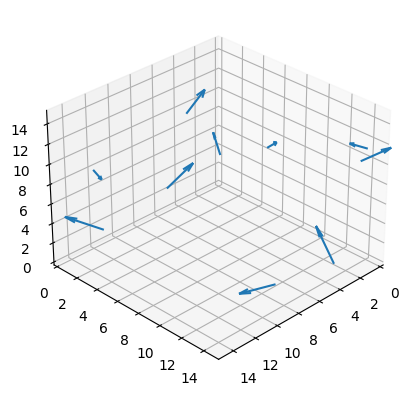

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate example data
prev_pts = np.random.rand(10, 3) * 15  # Example previous points
flow = np.random.rand(10, 3) * 5 - 2.5  # Example flow vectors

# Create a new figure and 3D axes
fig3d = plt.figure('p')
ax3 = fig3d.add_subplot(111, projection='3d')

# Plot the vectors
ax3.quiver(prev_pts[:, 0], prev_pts[:, 1], prev_pts[:, 2],
           flow[:, 0], flow[:, 1], flow[:, 2])

# Set plot limits
ax3.set_xlim([0, 15])
ax3.set_ylim([0, 15])
ax3.set_zlim([0, 15])

# Set viewpoint and perspective (adjust as needed)
ax3.view_init(elev=30, azim=45)

# Show the plot
plt.show()

In [69]:
# Extract the spatial subset
subset = nifti_data[x_start:x_end, y_start:y_end, z_start:z_end, :]

# Calculate the adjusted start indices
x_adj_start = x_start - x_start
y_adj_start = y_start - y_start
z_adj_start = z_start - z_start

# Create the array listing every point
indices = np.mgrid[x_adj_start:(x_end - x_start), y_adj_start:(y_end - y_start), z_adj_start:(z_end - z_start)]
points = np.transpose(indices.reshape(3, -1))

# Access the values at each point in the subset
subset_values = subset[points[:, 0], points[:, 1], points[:, 2], :]

In [84]:
points.shape

(6006, 3)